In [3]:
import duckdb

# In-memory DB
con = duckdb.connect()

con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")

con.execute("SET s3_region='ap-south-1';")

In [4]:
result = con.execute("""
SELECT COUNT(*) 
FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
""").fetchall()

print(result)

[(15901854,)]


In [5]:
sql = """
WITH ranked AS (
  SELECT
    court,
    COUNT(*) AS cases_disposed
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
  )
  WHERE
    year BETWEEN 2019 AND 2022
    AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
  GROUP BY court
)
SELECT court, cases_disposed
FROM ranked
ORDER BY cases_disposed DESC
LIMIT 1
"""

In [6]:
top_court = con.execute(sql).df()
print(top_court) 

  court  cases_disposed
0  9_13          817786


{"Which high court disposed the most cases from 2019 - 2022?": "9_13", "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": "nan", "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": ""}

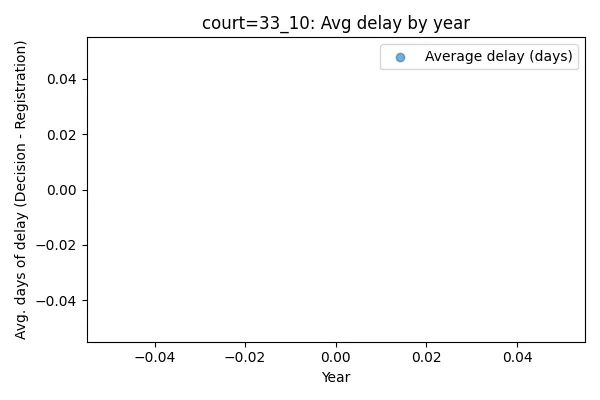

In [ ]:
# pip install duckdb matplotlib numpy pandas

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import json

# --- Connect & prepare DuckDB ---
con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # bucket is public

# --- 1) High court with most disposals (2019–2022) ---
most_cases_df = con.execute("""
SELECT court, COUNT(*) AS cases_disposed
FROM read_parquet(
  's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
WHERE year BETWEEN 2019 AND 2022
  AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
GROUP BY court
ORDER BY cases_disposed DESC
LIMIT 1
""").df()

most_cases_court = most_cases_df.iloc[0]["court"] if not most_cases_df.empty else None

# --- 2) Regression slope of (decision_date - date_of_registration) by YEAR for court=33_10 ---
# We compute per-year average delay (days), then regress avg_delay ~ year
delay_by_year = con.execute("""
WITH delays AS (
  SELECT
    year,
    DATE_DIFF('day', TRY_CAST(date_of_registration AS DATE), decision_date) AS delay_days
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=33_10/bench=*/metadata.parquet'
  )
  WHERE date_of_registration IS NOT NULL
    AND decision_date IS NOT NULL
)
SELECT
  year,
  AVG(delay_days) AS avg_delay_days
FROM delays
WHERE delay_days IS NOT NULL
GROUP BY year
ORDER BY year
""").df()

if len(delay_by_year) >= 2:
  x = delay_by_year["year"].to_numpy(dtype=float)
  y = delay_by_year["avg_delay_days"].to_numpy(dtype=float)
  slope, intercept = np.polyfit(x, y, 1)
  slope_val = float(slope)
else:
  slope_val = float("nan")  # not enough points

# --- 3) Scatterplot (year vs avg delay) with dotted red regression line ---
fig = plt.figure(figsize=(6, 4))
plt.scatter(delay_by_year["year"], delay_by_year["avg_delay_days"], alpha=0.6, label="Average delay (days)")
if len(delay_by_year) >= 2:
  xx = np.linspace(delay_by_year["year"].min(), delay_by_year["year"].max(), 200)
  yy = slope_val * xx + intercept
  plt.plot(xx, yy, "r:", label="Regression line")
plt.xlabel("Year")
plt.ylabel("Avg. days of delay (Decision - Registration)")
plt.title("court=33_10: Avg delay by year")
plt.legend()
plt.tight_layout()

buf = BytesIO()
fig.savefig(buf, format="webp")  # compact, stays well under 100k chars
plt.close(fig)
img_b64 = base64.b64encode(buf.getvalue()).decode("ascii")
data_uri = f"data:image/webp;base64,{img_b64}"

# --- 4) Emit JSON result ---
result = {
  "Which high court disposed the most cases from 2019 - 2022?": str(most_cases_court),
  "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": str(slope_val),
  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": data_uri
}

print(json.dumps(result, ensure_ascii=False))

In [26]:
slope_val
delay_by_year


,year,avg_delay_days


In [9]:
# pip install duckdb pandas

import duckdb
import pandas as pd
import json

# Connect to DuckDB (in-memory). Use duckdb.connect("mydb.duckdb") to persist.
con = duckdb.connect()

# Enable S3/Parquet support
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # public bucket region

# Query: court with most disposals between 2019 and 2022
sql_top = """
SELECT court, COUNT(*) AS cases_disposed
FROM read_parquet(
  's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
WHERE year BETWEEN 2019 AND 2022
  AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
GROUP BY court
ORDER BY cases_disposed DESC
LIMIT 1
"""

top_df = con.execute(sql_top).df()

# Also get the full ranking (optional)
sql_full = sql_top.replace("LIMIT 1", "")
full_df = con.execute(sql_full).df()

# Print answers
top_court = None if top_df.empty else top_df.iloc[0]["court"]
print("Top court (2019–2022):", top_court)

# If you want JSON output:
result = {
    "Which high court disposed the most cases from 2019 - 2022?": None if top_df.empty else {
        "court": top_df.iloc[0]["court"],
        "cases_disposed": int(top_df.iloc[0]["cases_disposed"])
    }
}
print(json.dumps(result, ensure_ascii=False, indent=2))

# (Optional) Show full ranking as a table
# print(full_df.head(25).to_string(index=False))

Top court (2019–2022): 9_13
{
  "Which high court disposed the most cases from 2019 - 2022?": {
    "court": "9_13",
    "cases_disposed": 817786
  }
}


In [34]:
# pip install duckdb pandas numpy

import duckdb
import numpy as np
import pandas as pd

# Connect
con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # public bucket

# Query: average delay per year for court=33_10
delay_by_year = con.execute("""
WITH delays AS (
  SELECT
    year,
    DATE_DIFF('day', TRY_CAST(TRY_STRPTIME(date_of_registration, '%d-%m-%Y') AS DATE), decision_date) AS delay_days
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=33_10/bench=*/metadata.parquet'
  )
  WHERE date_of_registration IS NOT NULL
    AND decision_date IS NOT NULL
)
SELECT
  year,
  AVG(delay_days) AS avg_delay_days
FROM delays
WHERE delay_days IS NOT NULL
GROUP BY year
ORDER BY year
""").df()

# Regression: avg_delay_days ~ year
if len(delay_by_year) >= 2:
    x = delay_by_year["year"].to_numpy(dtype=float)
    y = delay_by_year["avg_delay_days"].to_numpy(dtype=float)
    slope, intercept = np.polyfit(x, y, 1)
    slope_val = float(slope)
else:
    slope_val = float("nan")

print({
    "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": slope_val
})

{"What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": -21.07628484290379}


In [14]:
len(delay_by_year)

0

In [1]:
# pip install duckdb pandas

import duckdb
import pandas as pd
import json

# Connect to DuckDB (in-memory). Use duckdb.connect("mydb.duckdb") to persist.
con = duckdb.connect()

# Enable S3/Parquet support
# con.execute("INSTALL httpfs; LOAD httpfs;")
# con.execute("INSTALL parquet; LOAD parquet;")
# con.execute("SET s3_region='ap-south-1';")  # public bucket region

# Query: court with most disposals between 2019 and 2022
sql_top = """
INSTALL httpfs; LOAD httpfs;
INSTALL parquet; LOAD parquet;

SELECT year, AVG(DATEDIFF(\'day\', TRY_CAST(TRY_STRPTIME(date_of_registration, \'%d-%m-%Y\') AS DATE), decision_date)) AS avg_delay_days FROM read_parquet(\'s3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet?s3_region=ap-south-1\') WHERE court = \'33_10\' GROUP BY year ORDER BY year;
"""

top_df = con.execute(sql_top).df()

In [2]:
top_df

,year,avg_delay_days
0,1995,347.000000
1,1996,2425.500000
2,1997,209.000000
3,1999,-484.000000
4,2000,809.000000
5,2001,1024.350877
6,2002,1668.532683
7,2003,1228.799087
8,2004,1455.112920
9,2005,1477.061947


In [3]:
from typing_extensions import Dict, List, TypedDict, Annotated, Optional, Any, Tuple
from pydantic import BaseModel, Field, ConfigDict
import re
import subprocess
import sys
import os

import pandas as pd
import duckdb

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema import BaseMessage

from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AnyMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool

from fastapi import FastAPI, UploadFile, File, Form, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse
import uvicorn

from agents.wikipedia import Wikipedia
from agents.sessionstore import SessionStore
from agents.plot import ScatterPlot



In [19]:

class ParsedBlocks(BaseModel):
    model_config = ConfigDict(extra='forbid')
    content: Dict[str, Any]

In [13]:
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

In [22]:
prompt = """content='{\n  "Which high court disposed the most cases from 2019 - 2022?": "9_13",\n  "What\'s the regression slope of the date_of_registration - decision_date by year in the court=33_10?": 5.448544,\n  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAFoCAYAAACPNyggAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAASdAAAEnQB3mYfeAAAUohJREFUeJzt3Ql8DPf7B/BHQuKIJELiFsR9hqKl7lup1q11VauuVtXRS7VKVQ+ql/Kj7b/aoqqUUj0VrZu4r7jFLYmQCLkz/9fnm87abDan3Uw2+3m/XisyO7MzOzvZZ77X8y2gaZomRERElKtccnd3REREBAzAREREBmAAJiIiMgADMBERkQEYgImIiAzAAExERGQABmAiIiIDMAATEREZgAGYiIjIAAzAREREBmAAJiIiMgADMBERkQEYgImIiAzAAExERGQABmAiIiIDMAATEREZgAGYiIjIAAzAREREBmAAJiIiMgADMBERkQEYgImIiAzAAExERGQABmAiIiIDMAATERE5QwCOj4+XO3fu5PZuiYiInCMAL1++XCZMmJBq2fTp08XDw0O8vb2lV69eEh0dnaPXxnbTpk2Trl27io+PjxQoUEAWL16cZr2nnnpKPWf5qFWrVpb3tXbtWmncuLEULlxYKlWqpPabmJiYo+MmIiLSFRQ7+fDDD6VRo0am37dv364CcPfu3aV27dry2WefyTvvvCPvvvtutl87PDxcZsyYoQJiw4YNZfPmzemu6+7uLl9++WWqZV5eXlnaz2+//SaPP/64tG3bVh3v4cOHZebMmRIaGioLFizI9nETERHZPQCfOXNGhg0bZvp92bJlUqZMGVm9erUULFhQkpOTZdWqVTkKwGXLlpWrV6+q1wsKCpKmTZumuy72NXjw4By9h8mTJ0uDBg3kzz//VK8Dnp6d"\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 6389, 'prompt_tokens': 20959, 'total_tokens': 27348, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 5696, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C59gfnCPxXhvV3pLkBR0YIa2yTNrA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--8d5e1c96-dab3-4047-9ab0-4f266bd9100d-0' usage_metadata={'input_tokens': 20959, 'output_tokens': 6389, 'total_tokens': 27348, 'input_token_details': {'audio': 0, 'cache_read': 1408}, 'output_token_details': {'audio': 0, 'reasoning': 5696}} """

In [23]:
# Extract between content=' ... '
match = re.search(r"content='({.*?})'", prompt, re.DOTALL)
if match:
    json_str = match.group(1)  # This is the JSON string
    parsed = json.loads(json_str)
    values = list(parsed.values())
    print(values)

['9_13', 5.448544, '']


In [16]:
match = re.search(r"content='(.*?)'\s", prompt, re.DOTALL)
if not match:
    raise ValueError("Could not find JSON content")
prompt = match.group(1)

In [21]:
parsed = ParsedBlocks(content=json.loads(prompt))

In [20]:
parsed: ParsedBlocks = llm.with_structured_output(ParsedBlocks).invoke(prompt)

/Users/weigfhx/Library/CloudStorage/OneDrive-Allianz/GitHub/project-data-analyst-agent/.venv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:425: UserWarning: Invalid schema for OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. Specify `method="function_calling"` instead or update your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas
  warnings.warn(message)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'ParsedBlocks': In context=('properties', 'content'), 'additionalProperties' is required to be supplied and to be false.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}

In [25]:
text = """{\n  "Which high court disposed the most cases from 2019 - 2022?": "9_13",\n  "What\'s the regression slope of the date_of_registration - decision_date by year in the court=33_10?": 5.448544,\n  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": "data:image/webp;base64,UklGRpoVAABXRUJQVlA4II4VAABwWgCdASrwALQAPm0ylUgkIqIhJLHcAIANiWVu/Gf4w+mVhBxUl62tdsKn2P5KP0z9wH5x/T34AP1C6Uv8l9AH8z/xvrH+hT0AP611AvoAeXF7KP98/5PpVasf4h/mX4y+An9j/JDzt8IPmT2z9VL+A8E3QH+T9DP5F9aPv/5vf3r2Z/ufg78Vf6/1Avx3+U/2H80v7H6eewrzX/M/4/+o+wF6m/OP8f/Z/yA9Bb+z9A/yP+2f7/3AP5J/Nf83+cv+P+GP7j/wvG1+nf4b/J/2/8qvsB/lv85/xf90/b3+4f//7VP4D/g/4T/U/+n/h+zX82/v/+4/x3+Q/Y37BP5T/QP9H/cP87/8f87////v933sB/af2Rf1o/7JoNUX7SmL4qddsrT+k1JieDKTwf+Svdih5nRRhW+4lDQnd0FbTW/kZ1ZAzm4EiMl/PzOWXn0Bd6vU1PQRyVJjtsJuSRqAOxOVvkGIbDGN1QjQI6gnfjn2sRZPfhsVZVdhY2OfKkp8pyfDL3Pljcsrdguc+YNapivvlWc9uCXYjlO6dYMoOaHPZIBzMzuzNzFyPoKIb1cku1nkzx+oOB+/n3M7n67tgyBrZx6h2HeVgNO/sWJchXsLEmWcCnQJ+83hH8fExucpJvF+OkvvbU9yJk12aFeQJA6PCganrM02Jq1Fwb4LUnHOmUf7lKcUvrBesnXg+5PwpFvjt4uavDyu+igvDise8ua7hnAzPz/7iB7gO5dDbL+ipBtrRCjIFsgVqKI2koEP3Muo8pIFdsjSGbyaA1iXo7/98BZUZRd18OL2XzJ7Y51vg42VfIhmLSnPra9Jk1/EPgzkHBynsbFh8ox8iRPdWtqGgoddy01Xr0B/aFkG8lsx6ZS9iINrbMTKP9DBTE0VBLRw3QKvWnL8en/MG2wxjiqF368JY/keTlu7IeuYA3D+eJqr/bvRd4SEa01XUHJS6j88lBwc1HNRzJAA/v9NDHYUzMVM+CBKZ81HHdKbOn4FQPLm2yBs40BeVKkm/H/+Uy8LjiOKkPzOfl1Z21NeoTijZRfBHkL4+5ob2meDz2lV3Gwqt+qc+dt1YmZYCwqko/8+/MVV8vbIP5UsR2+Wnn/OPLGDJPmtzYdQ6Kt0GlxLGzJG97Bersi+TOEt6XWumm9/nrcnGbrNtUcYnGfKHl+SmMWhvWf37WGV13L/hNyyo6f4Uf+F8BxbNvNb5uPSX5/l7987vgqKMZQvqlZjT8qniRFh/8MYReuSVhv3YFAHYW+eseVg/ZSG6K90YmMgDIIklCGE5rwPU33LQnF6lxSjrJ2j6ymSPc8Tv8V+QdWV3bVRpUI+BFhM0kh+OXiBU+eLH4WpQi1KHwUczuThBKUGoAuWdVr190NzHEU+TjjnRj+ejz7n0059+08ZUq5DuN7uRqzlLscBKsybFKInZlCbDAv/uAN9L0veKRl18Kl8ZaHeK7YnrXst+WEZ5wrkpu11h8PltJMaIV/1RPUDdWQM9euJ84GpCPn4i1hL8qo7maQWpL/D0jzXnQjX4WV71XKNuZy6BdxOY4eGzwMtx8TyCD+n4AKx9QITwR1MQqnqREBH67MSyHmqy+cu+R+9f1W9a2OF52Rv1bg2s8aLjo+nYj2qnR12vop79TJoM6NcNwvqFMpQr3LIcs9KTTfxH1WjtBDvy4ftu5AFzl83sNBjad1xvanq8Igw4lGhd3G3w/WUXrdD4b6VTrnyGde8jtUoavLh34GGrqZ1adf8zEDplKFqqQH1ft775D/BR5iwzRLp4FbkaV3B1ShCYQqJTf8/rqcrXe9B4nhTK60Bs1+6jOd6OPouVP13AmZ1Z5ds05DfXLG5/wIQFyM+AWeTQWvOkXxXUiA/afsq4ObuGv4AVul5XDZuGRMxK9bV6wEjyLFfaDDz3hieL4DH1q8d11aw+1DbnzLcVIVv1b9wHxH4zt1d722pySt/79KLVE4eDCCIh7SzTWm6N/1o3DsePx8lGZy8u8ZgKFT0tnGtR184ZLw1XGgf7pbJ579y/SBgwxFMakIpD5/NhborHd17vyMY7If5pW1MhQqky8Avn4L4p/xF55+0oYKsdyKe9Aa6PHwE3rPi6WCmsHnkYn74svQyonr6o80Wjf/JguDvOfHW5eVFXGGUyZVS29j2MqySh+OwakyKAZ588GDJT1DCXXMzsBTgstzQEJQQCCmiOMkqh+343Wo5G5/Geio9cdkDjMnNCDLjR3XrxqeciAlP8wzFRkf3heMgRdkUQ5svU9KpzZxyzFuoHd2NIQ/376Lo+xHE6IOOlUCFJ7IjRinz4UpLFpU7HTNZyznNIPeTg3gxtvxSUOJbRFaWPbzsNxJDitjToToqNpqZBrcYHWYKiwuYCiRudN+JNJpIl4zjkpdjiS+I9BLcSN8GOHguB7YEt2KSxwKRQ2flvb0lTuSAAfHDEpUv/gAfGEz3PdZh1/lQcfvGUqY3/I0fnmKAAlhNGjGmEia20/XwP0ucny23D+nPkhR7S0DZPh5MHkbYomaniQbxelbnO/oJEzc2iQlEFBNwiM+6BtXB70ASKd9FarUC23CY9peSYyLXTkLqce+oVbhxrUgiKqt+QcDfhW/ymzVFWkIKAMcBDeoTahSbbdh0IaNWohKD3dxmOYgdk2m59eDW2ivEtWxpqB0ehXQ+sJjG2GTJ0xaQZBehSzM3Hc83rPB6H9kXq0GfgpaXq3XvRpBDP96YMFbFBTJ5NyjNtW2PYkFAWSEYG1OQqTImC8fNBnao4Pbeiao+fzLUFRNtUYtu7S79zABPwVfe8qF21JLP8BXN7SgTKqShMYnigivfj6GYwmkC+sttVWWJCoaicvQg7ZFj7ALIP5tRYX/ujP9pxW+5GMmcDuDGWKYIZYlGp46MwLuXg64dPjwRBK30aVJH8oo7JHdB3T5RJkhyVlVr0DZljzJOh45VLOEXJ9zuU0//eYYwq9aJ5PXu5tg41eySyl1seB3ZTrFRWrKiM0pLvzePgKMTdwgrl35umeleMaPypsLx/kaXy663j2WKJORmxJMwAQsPurLV4V5kMZgiZeKTf4cTX4r2GKBHF81Gq6ZjS1IyzXHwuEy8Hjc3fFNeh1DxYHsxhhvhmgrQLOQqp42IVv6+PubGRjZ1npPm6tvVHfU8M1ALB57+fzLhmMjhctuxHX25/+2VhjyKT0gT214xis4cJgv8ITbhzLlb6vlRa/H83XUjVG3oWWmFYLKlgSeqNuOhfrRSLG2H05DtLlll7bx72THVY45MabZHJ0wm7u2GKOoWVMQfF98pru0gE067PIto4rt5onjK4WTZBdQvtCyuCjcY+BvBM9abAJxoT64NL0wGIJIKC+M3H5/T+EIRGrlEcqc0IdiqUTIrpt/GZyL3DqLasLYnzyRiOtr8ii/OPWuled39lRfHSFAYqvOysVEM4LDZU5DjtUx7t+uIzu+MxFpbCt5OBZHj94ViIhgmoXgKNfCimfWGwdepRCCfIJgTn6mIgyU96ypWlAVjfE2dTK2m15nN1I7SFSGTkVQq4+Z7MJapQExDI9NDxT3hmpwUJE8Ywj5mgf4G0A6cYexxjMkgMV0vaESk7rY3LeWd2+WlV8TJfkk6FAJyZ6DdqAqh5dlg6ibqCu+6eQxJ0oV5q+IGt2buxaaqMtyor5oJ2MXiGKQ73wZpMXG/ysAKweW13qTh8PrInfCl+M2SjRzEp/NilNdr+q6CxbZi2/q6HYABt/mum/6PpNlctRUU6LTVfvr3GDq0yJIzzrzkvE9/3c7EAgVMijaHkcLrSP+zrU2rBV1DPkBzUaCku7hHez2A75zGpezAj+/4m4Eq23UJcHd4AyUrgBxr4CQq2xMeCBFYVidPKtcZb6gW2EJpbpqPSkRcYkSwBV8i+7FGH0Qfkzkz6eAHXkcAjtsHubtm2Q6eNlCxoszFkxAPp5H3ilNYQBTGAJkjyA017KpPk2pDCpte0kiFiylgyfUXEFqZ0VIpVI26JGWrCXibPQgBvUfAauimdSB//9LGFTMxAvSltZpdfc20NEPtcheV/Rwjso2YfXDSe4naf+MB3vDGH1qE5vVOBjigc3gubBt4q/m44h4m2m0VQDsIo8zzlBMc5pQfx6CTPjY6k4Etr+zJWTbNX+kmUEix6KygzVowGL27rPio/BB..." \n}"""

In [26]:
pattern = re.compile(
        r'(:\s*)'                              # group 1: colon + spaces
        r'(-?(?:\d+(?:\.\d+)?(?:[eE][+\-]?\d+)?'  # number (int/float/exp)
        r'|true|false|null))'                  # or booleans/null
        r'(\s*[,}\]])'                         # group 3: terminator
    )
fixed = pattern.sub(r'\1"\2"\3', text)

In [29]:
fixed

'{\n  "Which high court disposed the most cases from 2019 - 2022?": "9_13",\n  "What\'s the regression slope of the date_of_registration - decision_date by year in the court=33_10?": "5.448544",\n  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": "..." \n}'

In [27]:
data = json.loads(fixed)

In [28]:
data

{'Which high court disposed the most cases from 2019 - 2022?': '9_13',
 "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": '5.448544',
 'Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters': '...'}

In [36]:
text = """messages [HumanMessage(content='Scrape the list of highest grossing films from Wikipedia. It is at the URL:\nhttps://en.wikipedia.org/wiki/List_of_highest-grossing_films\n\nAnswer the following questions and respond with a JSON array of strings containing the answer.\n\n1. How many $2 bn movies were released before 2000?\n2. Which is the earliest film that grossed over $1.5 bn?\n3. What\'s the correlation between the Rank and Peak?\n4. Draw a scatterplot of Rank and Peak along with a dotted red regression line through it.\n   Return as a base-64 encoded data URI, `"data:image/png;base64,iVBORw0KG..."` under 100,000 bytes.', additional_kwargs={}, response_metadata={}, id='34dc06b3-a5cc-4a1a-a190-d88dca50a372'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KOkoSxhejxA95A1Kd42j3ph2', 'function': {'arguments': '{"url":"https://en.wikipedia.org/wiki/List_of_highest-grossing_films"}', 'name': 'search_wikipedia_by_url'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2792, 'prompt_tokens': 969, 'total_tokens': 3761, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 2752, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C5R15PMXJnK9DedDgxhBhdFd2RE5h', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--951f71bb-94b5-4ddd-8021-cead5a2e3788-0', tool_calls=[{'name': 'search_wikipedia_by_url', 'args': {'url': 'https://en.wikipedia.org/wiki/List_of_highest-grossing_films'}, 'id': 'call_KOkoSxhejxA95A1Kd42j3ph2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 969, 'output_tokens': 2792, 'total_tokens': 3761, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 2752}}), ToolMessage(content="{'Rank:Peak:Title:Worldwide gross:Year:Ref':     Rank  Peak                                          Title Worldwide gross  Year  Ref\n0      1     1                                         Avatar  $2,923,706,026  2009  NaN\n1      2     1                              Avengers: Endgame  $2,797,501,328  2019  NaN\n2      3     3                       Avatar: The Way of Water  $2,320,250,281  2022  NaN\n3      4     1                                        Titanic  $2,257,844,554  1997  NaN\n4      5     5                                       Ne Zha 2  $2,212,300,000  2025  NaN\n5      6     3                   Star Wars: The Force Awakens  $2,068,223,624  2015  NaN\n6      7     4                         Avengers: Infinity War  $2,048,359,754  2018  NaN\n7      8     6                        Spider-Man: No Way Home  $1,922,598,800  2021  NaN\n8      9     8                                   Inside Out 2  $1,698,863,816  2024  NaN\n9     10     3                                 Jurassic World  $1,671,537,444  2015  NaN\n10    11     7                                  The Lion King  $1,656,943,394  2019  NaN\n11    12     3                                   The Avengers  $1,518,815,515  2012  NaN\n12    13     4                                      Furious 7  $1,515,341,399  2015  NaN\n13    14    11                              Top Gun: Maverick  $1,495,696,292  2022  NaN\n14    15    10                                       Frozen 2  $1,450,026,933  2019  NaN\n15    16    14                                         Barbie  $1,447,038,421  2023  NaN\n16    17     5                        Avengers: Age of Ultron  $1,402,809,540  2015  NaN\n17    18    15                    The Super Mario Bros. Movie  $1,360,847,665  2023  NaN\n18    19     9                                  Black Panther  $1,347,280,838  2018  NaN\n19    20     3  Harry Potter and the Deathly Hallows – Part 2  $1,342,139,727  2011  NaN\n20    21    20                           Deadpool & Wolverine  $1,338,073,645  2024  NaN\n21    22     9                       Star Wars: The Last Jedi  $1,332,539,889  2017  NaN\n22    23    12                 Jurassic World: Fallen Kingdom  $1,308,473,425  2018  NaN\n23    24     5                                         Frozen  $1,290,000,000  2013  NaN\n24    25    10                           Beauty and the Beast  $1,263,521,126  2017  NaN\n25    26    15                                  Incredibles 2  $1,242,805,359  2018  NaN\n26    27    11                        The Fate of the Furious  $1,238,764,765  2017  NaN\n27    28     5                                     Iron Man 3  $1,214,811,252  2013  NaN\n28    29    10                                        Minions  $1,159,444,662  2015  NaN\n29    30    12                     Captain America: Civil War  $1,153,337,496  2016  NaN\n30    31    20                                        Aquaman  $1,148,528,393  2018  NaN\n31    32     2  The Lord of the Rings: The Return of the King  $1,147,997,407  2003  NaN\n32    33    24                      Spider-Man: Far From Home  $1,132,679,685  2019  NaN\n33    34    23                                 Captain Marvel  $1,128,274,794  2019  NaN\n34    35     5                 Transformers: Dark of the Moon  $1,123,794,079  2011  NaN\n35    36     7                                        Skyfall  $1,108,594,137  2012  NaN\n36    37    10                Transformers: Age of Extinction  $1,104,054,072  2014  NaN\n37    38     7                          The Dark Knight Rises  $1,081,169,825  2012  NaN\n38    39    31                                          Joker  $1,074,458,282  2019  NaN\n39    40    32               Star Wars: The Rise of Skywalker  $1,074,144,248  2019  NaN\n40    41    30                                    Toy Story 4  $1,073,394,593  2019  NaN\n41    42     4                                    Toy Story 3  $1,066,970,811  2010  NaN\n42    43     3     Pirates of the Caribbean: Dead Man's Chest  $1,066,179,747  2006  NaN\n43    44    44                                        Moana 2  $1,059,242,164  2024  NaN\n44    45    20                   Rogue One: A Star Wars Story  $1,057,420,387  2016  NaN\n45    46    34                                        Aladdin  $1,050,693,953  2019  NaN\n46    47     2      Star Wars: Episode I – The Phantom Menace  $1,046,515,409  1999  NaN\n47    48     6    Pirates of the Caribbean: On Stranger Tides  $1,045,713,802  2011  NaN\n48    49     1                                  Jurassic Park  $1,037,535,230  1993  NaN\n49    50    24                                Despicable Me 3  $1,034,800,131  2017  NaN, 'Rank:Title:Worldwide gross (2024 $):Year':    Rank                         Title Worldwide gross (2024 $)  Year\n0     1            Gone with the Wind           $4,450,000,000  1939\n1     2                        Avatar           $4,056,000,000  2009\n2     3                       Titanic           $3,769,000,000  1997\n3     4                     Star Wars           $3,652,000,000  1977\n4     5             Avengers: Endgame           $3,357,000,000  2019\n5     6            The Sound of Music           $3,059,000,000  1965\n6     7    E.T. the Extra-Terrestrial           $2,990,000,000  1982\n7     8          The Ten Commandments           $2,827,000,000  1956\n8     9                Doctor Zhivago           $2,680,000,000  1965\n9    10  Star Wars: The Force Awakens           $2,642,000,000  2015, 'Year:Title:Worldwide gross:Budget:Ref':      Year                     Title Worldwide gross        Budget  Ref\n0    1915     The Birth of a Nation     $50,000,000      $110,000  NaN\n1    1916               Intolerance      $1,750,000      $385,907  NaN\n2    1917                 Cleopatra        $500,000      $300,000  NaN\n3    1918                    Mickey      $8,000,000      $250,000  NaN\n4    1919           The Miracle Man      $3,000,000      $120,000  NaN\n..    ...                       ...             ...           ...  ...\n147  2021   Spider-Man: No Way Home  $1,922,598,800  $200,000,000  NaN\n148  2022  Avatar: The Way of Water  $2,320,250,281  $350,000,000  NaN\n149  2023                    Barbie  $1,447,038,421  $128,000,000  NaN\n150  2024              Inside Out 2  $1,698,863,816  $200,000,000  NaN\n151  2025                  Ne Zha 2  $2,212,300,000   $80,000,000  NaN\n\n[152 rows x 5 columns], 'Established:Title:Record-setting gross:Ref':     Established                       Title Record-setting gross  Ref\n0          1915       The Birth of a Nation           $5,200,000  NaN\n1          1940       The Birth of a Nation          $15,000,000  NaN\n2          1940          Gone with the Wind          $32,000,000  NaN\n3          1963          Gone with the Wind          $67,000,000  NaN\n4          1966          The Sound of Music         $114,600,000  NaN\n5          1971          Gone with the Wind         $116,000,000  NaN\n6          1972               The Godfather         $127,600,000  NaN\n7          1976                        Jaws         $193,700,000  NaN\n8          1978                   Star Wars         $410,000,000  NaN\n9          1982                   Star Wars         $530,000,000  NaN\n10         1983  E.T. the Extra-Terrestrial         $619,000,000  NaN\n11         1993  E.T. the Extra-Terrestrial         $701,000,000  NaN\n12         1993               Jurassic Park         $912,667,947  NaN\n13         1998                     Titanic       $1,843,373,318  NaN\n14         2010                      Avatar       $2,743,577,587  NaN\n15         2010                      Avatar       $2,788,416,135  NaN\n16         2019           Avengers: Endgame       $2,797,501,328  NaN\n17         2021                      Avatar       $2,847,397,339  NaN\n18         2022                      Avatar       $2,923,706,026  NaN, 'Rank:Series:Total worldwide gross:No. of films:Average of films:Highest-grossing film': Empty DataFrame\nColumns: [Rank, Series, Total worldwide gross, No. of films, Average of films, Highest-grossing film]\nIndex: [], 'vteBox office:vteBox office.1':        vteBox office                                    vteBox office.1\n0             Topics  Box office territory Box-office bomb list Fast...\n1   Highest-grossing  General Highest-grossing films worldwide Box o...\n2            General  Highest-grossing films worldwide Box office ad...\n3           Animated  Decades 1980s 1990s 2000s 2010s 2020s Live-act...\n4           By genre  Action Christmas Documentaries Fantasy Horror ...\n5          By origin  Bangladeshi Czech Filipino Greek Mexican India...\n6          By region  Australia Austria China France Germany Hong Ko...\n7          By person                         Actors Directors Producers\n8            Records  Avatar Star Wars: The Force Awakens Avengers: ...\n9             Awards  Box Office Entertainment Awards Crystal Film D...\n10          Websites  Box Office Mojo The Numbers ShowBIZ Data Box O...\n11             Other  Box office futures Box Office Poison Boxoffice...\n12           Related  Blockbuster 100 Crore Club 1000 Crore Club Bes...\n13          Category                                           Category, 'vteMedia franchises:vteMedia franchises.1':   vteMedia franchises                              vteMedia franchises.1\n0        Media series  Animated series anime series Book series Partw...\n1         Media lists  Multimedia franchises print television series ...\n2    Highest-grossing                       Media franchises Film series\n3        Best-selling  Comic book series manga series Video game fran...\n4            Category                                           Category}", name='search_wikipedia_by_url', id='484bc59b-1996-4855-886d-a88cd725d1ca', tool_call_id='call_KOkoSxhejxA95A1Kd42j3ph2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RNemxyojZ54yqgkFmuiZY36k', 'function': {'arguments': '{"data": [{"Rank": 1, "Peak": 1}, {"Rank": 2, "Peak": 1}, {"Rank": 3, "Peak": 3}, {"Rank": 4, "Peak": 1}, {"Rank": 5, "Peak": 5}, {"Rank": 6, "Peak": 3}, {"Rank": 7, "Peak": 4}, {"Rank": 8, "Peak": 6}, {"Rank": 9, "Peak": 8}, {"Rank": 10, "Peak": 3}, {"Rank": 11, "Peak": 7}, {"Rank": 12, "Peak": 3}, {"Rank": 13, "Peak": 4}, {"Rank": 14, "Peak": 11}, {"Rank": 15, "Peak": 10}, {"Rank": 16, "Peak": 14}, {"Rank": 17, "Peak": 5}, {"Rank": 18, "Peak": 15}, {"Rank": 19, "Peak": 9}, {"Rank": 20, "Peak": 3}, {"Rank": 21, "Peak": 20}, {"Rank": 22, "Peak": 9}, {"Rank": 23, "Peak": 12}, {"Rank": 24, "Peak": 5}, {"Rank": 25, "Peak": 10}, {"Rank": 26, "Peak": 15}, {"Rank": 27, "Peak": 11}, {"Rank": 28, "Peak": 5}, {"Rank": 29, "Peak": 10}, {"Rank": 30, "Peak": 12}, {"Rank": 31, "Peak": 20}, {"Rank": 32, "Peak": 2}, {"Rank": 33, "Peak": 24}, {"Rank": 34, "Peak": 23}, {"Rank": 35, "Peak": 5}, {"Rank": 36, "Peak": 7}, {"Rank": 37, "Peak": 10}, {"Rank": 38, "Peak": 7}, {"Rank": 39, "Peak": 31}, {"Rank": 40, "Peak": 32}, {"Rank": 41, "Peak": 30}, {"Rank": 42, "Peak": 4}, {"Rank": 43, "Peak": 3}, {"Rank": 44, "Peak": 44}, {"Rank": 45, "Peak": 20}, {"Rank": 46, "Peak": 34}, {"Rank": 47, "Peak": 2}, {"Rank": 48, "Peak": 6}, {"Rank": 49, "Peak": 1}, {"Rank": 50, "Peak": 24}], "xlabel": "Rank", "ylabel": "Peak", "title": "Rank vs Peak", "fmt": "png"}', 'name': 'scatter_plot'}, 'type': 'function'}, {'id': 'call_QeBl3yz2PyMIXodxMtmrZnms', 'function': {'arguments': '{"data": [{"Rank": 1, "Peak": 1}, {"Rank": 2, "Peak": 1}, {"Rank": 3, "Peak": 3}, {"Rank": 4, "Peak": 1}, {"Rank": 5, "Peak": 5}, {"Rank": 6, "Peak": 3}, {"Rank": 7, "Peak": 4}, {"Rank": 8, "Peak": 6}, {"Rank": 9, "Peak": 8}, {"Rank": 10, "Peak": 3}, {"Rank": 11, "Peak": 7}, {"Rank": 12, "Peak": 3}, {"Rank": 13, "Peak": 4}, {"Rank": 14, "Peak": 11}, {"Rank": 15, "Peak": 10}, {"Rank": 16, "Peak": 14}, {"Rank": 17, "Peak": 5}, {"Rank": 18, "Peak": 15}, {"Rank": 19, "Peak": 9}, {"Rank": 20, "Peak": 3}, {"Rank": 21, "Peak": 20}, {"Rank": 22, "Peak": 9}, {"Rank": 23, "Peak": 12}, {"Rank": 24, "Peak": 5}, {"Rank": 25, "Peak": 10}, {"Rank": 26, "Peak": 15}, {"Rank": 27, "Peak": 11}, {"Rank": 28, "Peak": 5}, {"Rank": 29, "Peak": 10}, {"Rank": 30, "Peak": 12}, {"Rank": 31, "Peak": 20}, {"Rank": 32, "Peak": 2}, {"Rank": 33, "Peak": 24}, {"Rank": 34, "Peak": 23}, {"Rank": 35, "Peak": 5}, {"Rank": 36, "Peak": 7}, {"Rank": 37, "Peak": 10}, {"Rank": 38, "Peak": 7}, {"Rank": 39, "Peak": 31}, {"Rank": 40, "Peak": 32}, {"Rank": 41, "Peak": 30}, {"Rank": 42, "Peak": 4}, {"Rank": 43, "Peak": 3}, {"Rank": 44, "Peak": 44}, {"Rank": 45, "Peak": 20}, {"Rank": 46, "Peak": 34}, {"Rank": 47, "Peak": 2}, {"Rank": 48, "Peak": 6}, {"Rank": 49, "Peak": 1}, {"Rank": 50, "Peak": 24}], "xlabel": "Rank", "ylabel": "Peak", "title": "Rank vs Peak (regression)", "fmt": "png"}', 'name': 'scatter_plot_regression'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9343, 'prompt_tokens': 3880, 'total_tokens': 13223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 8448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C5R1K6xB6EqZfXvR3FXZ67nMpb71O', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--58d143c3-1fbc-460b-8564-c07eeb3163e7-0', tool_calls=[{'name': 'scatter_plot', 'args': {'data': [{'Rank': 1, 'Peak': 1}, {'Rank': 2, 'Peak': 1}, {'Rank': 3, 'Peak': 3}, {'Rank': 4, 'Peak': 1}, {'Rank': 5, 'Peak': 5}, {'Rank': 6, 'Peak': 3}, {'Rank': 7, 'Peak': 4}, {'Rank': 8, 'Peak': 6}, {'Rank': 9, 'Peak': 8}, {'Rank': 10, 'Peak': 3}, {'Rank': 11, 'Peak': 7}, {'Rank': 12, 'Peak': 3}, {'Rank': 13, 'Peak': 4}, {'Rank': 14, 'Peak': 11}, {'Rank': 15, 'Peak': 10}, {'Rank': 16, 'Peak': 14}, {'Rank': 17, 'Peak': 5}, {'Rank': 18, 'Peak': 15}, {'Rank': 19, 'Peak': 9}, {'Rank': 20, 'Peak': 3}, {'Rank': 21, 'Peak': 20}, {'Rank': 22, 'Peak': 9}, {'Rank': 23, 'Peak': 12}, {'Rank': 24, 'Peak': 5}, {'Rank': 25, 'Peak': 10}, {'Rank': 26, 'Peak': 15}, {'Rank': 27, 'Peak': 11}, {'Rank': 28, 'Peak': 5}, {'Rank': 29, 'Peak': 10}, {'Rank': 30, 'Peak': 12}, {'Rank': 31, 'Peak': 20}, {'Rank': 32, 'Peak': 2}, {'Rank': 33, 'Peak': 24}, {'Rank': 34, 'Peak': 23}, {'Rank': 35, 'Peak': 5}, {'Rank': 36, 'Peak': 7}, {'Rank': 37, 'Peak': 10}, {'Rank': 38, 'Peak': 7}, {'Rank': 39, 'Peak': 31}, {'Rank': 40, 'Peak': 32}, {'Rank': 41, 'Peak': 30}, {'Rank': 42, 'Peak': 4}, {'Rank': 43, 'Peak': 3}, {'Rank': 44, 'Peak': 44}, {'Rank': 45, 'Peak': 20}, {'Rank': 46, 'Peak': 34}, {'Rank': 47, 'Peak': 2}, {'Rank': 48, 'Peak': 6}, {'Rank': 49, 'Peak': 1}, {'Rank': 50, 'Peak': 24}], 'xlabel': 'Rank', 'ylabel': 'Peak', 'title': 'Rank vs Peak', 'fmt': 'png'}, 'id': 'call_RNemxyojZ54yqgkFmuiZY36k', 'type': 'tool_call'}, {'name': 'scatter_plot_regression', 'args': {'data': [{'Rank': 1, 'Peak': 1}, {'Rank': 2, 'Peak': 1}, {'Rank': 3, 'Peak': 3}, {'Rank': 4, 'Peak': 1}, {'Rank': 5, 'Peak': 5}, {'Rank': 6, 'Peak': 3}, {'Rank': 7, 'Peak': 4}, {'Rank': 8, 'Peak': 6}, {'Rank': 9, 'Peak': 8}, {'Rank': 10, 'Peak': 3}, {'Rank': 11, 'Peak': 7}, {'Rank': 12, 'Peak': 3}, {'Rank': 13, 'Peak': 4}, {'Rank': 14, 'Peak': 11}, {'Rank': 15, 'Peak': 10}, {'Rank': 16, 'Peak': 14}, {'Rank': 17, 'Peak': 5}, {'Rank': 18, 'Peak': 15}, {'Rank': 19, 'Peak': 9}, {'Rank': 20, 'Peak': 3}, {'Rank': 21, 'Peak': 20}, {'Rank': 22, 'Peak': 9}, {'Rank': 23, 'Peak': 12}, {'Rank': 24, 'Peak': 5}, {'Rank': 25, 'Peak': 10}, {'Rank': 26, 'Peak': 15}, {'Rank': 27, 'Peak': 11}, {'Rank': 28, 'Peak': 5}, {'Rank': 29, 'Peak': 10}, {'Rank': 30, 'Peak': 12}, {'Rank': 31, 'Peak': 20}, {'Rank': 32, 'Peak': 2}, {'Rank': 33, 'Peak': 24}, {'Rank': 34, 'Peak': 23}, {'Rank': 35, 'Peak': 5}, {'Rank': 36, 'Peak': 7}, {'Rank': 37, 'Peak': 10}, {'Rank': 38, 'Peak': 7}, {'Rank': 39, 'Peak': 31}, {'Rank': 40, 'Peak': 32}, {'Rank': 41, 'Peak': 30}, {'Rank': 42, 'Peak': 4}, {'Rank': 43, 'Peak': 3}, {'Rank': 44, 'Peak': 44}, {'Rank': 45, 'Peak': 20}, {'Rank': 46, 'Peak': 34}, {'Rank': 47, 'Peak': 2}, {'Rank': 48, 'Peak': 6}, {'Rank': 49, 'Peak': 1}, {'Rank': 50, 'Peak': 24}], 'xlabel': 'Rank', 'ylabel': 'Peak', 'title': 'Rank vs Peak (regression)', 'fmt': 'png'}, 'id': 'call_QeBl3yz2PyMIXodxMtmrZnms', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3880, 'output_tokens': 9343, 'total_tokens': 13223, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 8448}}), ToolMessage(content='Argument must be an image or collection in this Axes', name='scatter_plot', id='1dc2b68a-9e88-4b12-8e90-8b0b02904e18', tool_call_id='call_RNemxyojZ54yqgkFmuiZY36k'), ToolMessage(content='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAPAAAAC0CAYAAACqnKHoAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAJOgAACToB8GSSSgAAIwlJREFUeJztnQd8FNX2x09CICQhoRiSAKHX0CESiqGJiDQVBJEuCvp8CuoTC08REVDBiuUJ/D+C8gR5NkSlg5SHItJ7AkgJmAAJEEgvm/l/fgdm32azu9lNtszsnu/ns58tszP37uycOefee4qfoigKCYKgS/w93QFBEMqOCLAg6BgRYEHQMSLAgqBjRIAFQceIAAuCjhEBFgQdIwIsCDpGBFgQdIwIsCDoGBFgQdAxIsCCoGNEgMtAhQoVqH379tS6dWsaPHgwpaenl/lYVapUIVfRq1cvat68ObVr147uuOMOSkxMdFkfc3JyqGfPnmQwGEiL7Nmzh6ZMmVKmffPz86lHjx5UWFhIWkMEuAwEBQXRgQMH6MiRI1SjRg365JNPSKssW7aMDh48SOPHj6fnn3/eZe0sXryYhg4dyjc3U5xx0TvjpnD77bfThx9+WKZ9K1WqRH369KH//Oc/pDVEgMtJ165d6a+//uLXf/zxB7/v0KEDdevWzajxPv/8c76477nnHmratCm98MILJY6TlpbG+65evbrY5y+99FKxG8Rrr71G77zzDqWkpLBWUC2B//73vzb7ie+eOnWKX7/99tvUqVMnatu2Lc2YMcP4nfvvv59iY2OpVatWtGjRIrv7qN4o7rvvPn69detW6t69O917773UsmVLFkDcPNQ2Fy5cyN8rKiqiv//979SiRQvq27cvDRgwgL799lve1qBBA3rxxRepY8eO9M0339CGDRu4bbwfPnw4ZWZmGs8P2sBxp06dyp/h+zgnsDzwu9U+DRo0iF9fvXqVfyv26dKlCx06dMh4bh955BG2XBo1alRM4PF9/EbNgXhgwTFCQkL4ubCwUBk2bJiydu1afn/9+nWloKCAX2/cuFEZOnQov16yZInSsGFDJT09XcnJyVHq1aunJCUlGY918eJFJS4uTtmwYUOJtvbt26f06NHD+D4mJob3feedd5TZs2cb+3Hjxo0S+/bs2VPZvXs3v543b57y4IMPKuvXr1cmTZqkFBUVKQaDQRk4cKCybds2/s6VK1f4OTs7W2nVqpWSlpZmVx/z8vKUyMhI4/stW7YowcHByunTp/n9woULlVmzZvHr3NxcJTY2lrd98803Sv/+/bkfKSkpSrVq1fgzUL9+fWXu3Ln8OjU1VenevbuSmZnJ79966y1l5syZ3L9mzZrxbwHXrl3j59atWysXLlwo9hn6hN8KnnrqKeW1117j15s3b1batWvHr2fMmKF07dqV+4g2a9SooeTn5xvPcXh4uKI1Ajx9A9EjGO9B80HzxsTEsPYA169fZ1P15MmT5OfnRwUFBcZ9YIJVrVqVX0NjnDt3jurWrcvfwTZoWYwhzYE2v3z5MiUnJ1NqaipVr16d94M2g7bA/tAO6I8lRo8ezSY/NNpHH31E8+fPZ22G4wJoMvQXmgoaZ+XKlfz5+fPn+fPbbrut1D5CM1erVq3YZ3FxcdSwYUN+jfag5VTtivOEY+/YsYO1qb+/P0VFRVHv3r2LHWPEiBH8/Pvvv9OxY8d4HK+OSaGNq1atSpUrV6ZHH32UtauqYfG9hx9+mB588EG2fMxBu9999x2/vvPOO+nKlSt048YNfj9w4EAKDAzkR0REBF26dImio6N5aABTOiMjg0JDQ0kriAldjjEwhBAJTVQTd/r06XwRYmz8008/UW5urnEfXBAquBjUsWFAQACbrevXr7faHi5yXPwYg6kXNQRu+/btVKdOHb5Yly5danFfmH3o6w8//MCCj/5OmzaNP8MDZjUEACbmpk2baOfOnTxmhoCr/S+tjzgfpr8VhISEGF+jTdw81DbPnDlDd999d6nnWT0G9sdNUt0fwvzZZ59xvzBsGTZsGP388888RAELFiyg2bNn800I/YaA2ou1/wnk5eXxDUNLiACXg+DgYNZa7777Lv/R0CwQKHXcaw/Q1JgASkhIoLlz51r8DoR2xYoVLMQQZoCbR2RkJE2aNIkmTpxI+/bts6u9fv36cXvqGBJWBDQ8+g7tjt+EvkDr2dtH7IdxrrkQm7b56aefGi2SEydOUFZWFmtKaEKMhaHpcBOxBMapv/76q3EMj31xjMzMTO43xs7vv/8+33jAn3/+SZ07d6bXX3+datasyYJsCsbn6ngWbYaHh1NYWJjN84abAL5XsWJF0hJiQpcTaCpMhnz11Vc8OQUTGnd/mGL2gjs99sekD8wzTOyYgkklmG64OdSqVct44WEyChcUlnmsaWBzoPmOHz/OJijAvl9++SVrL2guDAmw9AShcaSPOC5M07vuuqtEm7jBnD17liegoE0hVLAIHnjgAdq8eTMPKWAdYLs6zDAF38cNceTIkawFAc5xaGgoT5zhxoHjvvfee7wNE2Yw0fEZTH9MZm3bts14PHWyCv8bblhffPFFqedty5YtDv2nbsPTg3DBO9i7d68yZswYh/fLyMjgZ0xINWrUiCeztMiQIUOUxMRERWto2oSGeYTJEGgJjCtNgcmGuyjMoWeeecZjfRRuAu2J8b+ja7aYeMIEHP5HzCFgMktr5Ofn80Rhs2bNSGv4QYpJo2DMBC8nmERY48PansqqVato9+7dbEphHAhhVs1CQfAVNK2BMb7D+McSv/32m3EmE+M3THIIgq+haQG2xbVr14wzh5j4gHeNIPgaup2FhuOAuviOsTJ8kk2BOx0e6rJC48aNPdJPQbAF1q+zs7PJ5wQYvsZwPIBDAxwMJkyYUGw71kvVNVN45Hz99dce6qmgJxRFoUMXrtOR5OvUunZVahtdldfBXQWWz8qD5gUYi/TwvkFgwOOPP86eQnCGx+wl1hIxe4m1WJnAEpwhvM+sOEBbT6RSRm4BhVauSL2a1aT5I2+6nWoRzQvwmjVrir2H2yCAG5293k6CYA/QvBDe6zk3PcbwjPcHz6dTu7rFfb21gm4nsQTB2cBshuY1Be/xuVYRARaEW2DMC7PZFLzH51pFBFgQboEJK4x5qwZVJH8/4me816r5rIsxsCC4Cz8/P56wwphXnYXWsvACEWBBMANCq3XB1aUJjXA21bUSThpYC0a42IULFzzdNUHwCLoRYES5QGix8I3gecR+IiYWQduzZs3ydPcEwSP460n7qvmTEKyNwHPkKEJWBzWroCD4Gv560b5whVTzQZkGMqjbBcEX0cUkFlK+wJ8Z2tc8kAGYJxM3D2Ywz4kkCN6CLgQYWQj379/PggzzGRkOkdcJmRJQMgO5jcwxD2YQBG9EFwJsmgkRJTKQ4RApVpFBH2k+7UlKJgjeiC4E2BRoXIDxsDomFgRfRdOTWKiNg3DBsWPHFqtygMoIqAqIKgFYB0ZOYUHwRTQrwEjSjaTjKNqF4ldqWQ6wdu1aTnCHXL8IL0SWfkHwRTQrwLaS1jVp0oSz86tLSsiYLwi+iGbHwBBMtQqBedI6lOjEzDQqFiCLAurj2FpGEgRvxV+PSesw6xwfH09Hjx616kqJJSQ4f0guLMGb8dd60jqApHVqaUkArauazXiGgAuCL6JZAUa5DVTfwyw0NC0KYSGpHRg1ahSn48Q6MMpx/OMf//B0dwUvR1EUjhNetuscP2uloImmS6s4C0krK2g1WyWi68rj6qtZDSwIWsxWWaQUz1bpaUSABUHH2SpFgAWvRnHC2FXL2So1uw4sCFoZu7a9la3S/DhayJslAix4LYecVGlBy9kqRYAFry1QtvjXM3TDyti1LAKoxWyVuhBgRBsNGTKEC34j+8ayZcu4ZOgLL7zAWToQH9ymTRtPd1PQmNl8I6eAzEe8Whm7+pQAw9tqx44dLKwoaIboo40bN9Lq1aspIyOD/va3v5Uogib4JofMzGYVVAgNDQygdtFVjbPHri4d6g50IcCmOa8gsCjW/csvv1D16tX5YRroIPg2Ryws+UBEB7etRenZBXTwwnXacSpNF6VDvWoZCTWCO3fuTB9//DH7SZtmpUSpUeTHEoTWFpZ8woIqUo+mNVl4teiM4fUaWPWN3rVrF7tEzpkzp1hWSiR6R45oUyQrpW/S1sqST56hyKozhtYmprxOgKFdVQFFbHCVKlVYaNPT09mkNg01VJGslL6Jn5UlH7yHMJuOjb1hQitA6zmxkJkDApuZmcmmMrJQLl68mBYsWED169fn7yHNrCDYWvLRsjOGVwqwaU4smMyNGjWikSNH8rbk5GQ6ceIEa2C9zyIK7sFPw84YPpcTa926dRQYGEh9+/bljJXQzoJgDxDa0Z3re4XwalqATesfmefEgmNHWloarwV37dqVZ6YFwRcJ0GNOLGzr3bs3m0XICz179uwS+0tSO8EX0GVOLLzGujDAM8bH5khSO8EX8JgAv/nmm8bXRUVFNHHiRLtzYqGYGVKRICcWZqQnT57s9v4Lgk/nxMLMcnBwME2ZMoXGjRtHAwYMoNGjR7ukLcmJJWgV3ebEevnll+nKlSs8CTVs2DCXCa+gD7Sa9VHrv8ntk1idOnUyrt3iB507d47eeOMNNqktVVgQvB9XZn309t/kdgHevXu3u5sUdJg5Y1PCJZq7NoHuaR2ly7C/Q07KBqLZZSQ4X6BIN7yqVNPi1Vdf9VR3BI2FAGblGWjBtj9p+R9JutTGR2xksnSmAHtsDIxZZQQioGwofJ2TkpI81RVBgyGAALd1vYb9tXZTJkt/T0YYPfPMMxyQj9IoUqTbd1EDDaoGVeTge3O0koO5rL/J34/42RXBEx4zoRFZlJubS9HR0Ww6p6SkeKorgoYCDdYdTaF/7zxHmXkGXYf9+bkpeMJjArxhwwb+kQsXLmRPK+S1EnwbXODQXMnXcr0m7K+dizNZekyAs7KyWHixFowavwhMqF27tsXvYnnp6aef5qyUderUoaVLl9IPP/xA77//PgUFBXG9YGhyQf94a9ifq/DYGHjMmDHshYJ4X5jT7777rtXv4ntIYrd9+3Zq0KABrVq1it577z3aunWr1QLfgjadJuxtWwthf4oOnEs8uowEF0dk1gC2Tk6tWrWMr5FaJzExkWJiYvg1AhumTp3qlj57A550mtCTw4aik756TAPDXEaOZ5jSSNRujwkMry2MnePj44tlpTQY/jfhIWi3VKaWy3Tqta9uF+C9e/dSv379OFE7lo9q1qzJwfuLFi2yuR9ig5F9A0KPfUyzUprmjVZBLDA0PB6SlVIbpTK1XKbTVX3NyiskrxLgJ598ksesCQkJtGLFCq628NRTT3GKHEtJ7RBOiECHESNG0IwZM6h58+bUtGlTOn78OAfyt2jRgsMLbcUDYwwteL5UppbLdDqjrxDWa1n5VFSk0IQlf1BugYHSMvPIqwQYIYRxcXE8fkXOK2v5rEyT2uXl5bHGhuAjBvj777/n2OD58+ezK+Yrr7zi7p+hW9zlYKC1tl3RV4yT07Pz6f+2n+b3i3ecoTVHUsjf34+e6NWE/P38qP5tIeRVk1hHjhwx5mnGCTB9bxqza5rUbtq0aRQVFVUs9xW0748//sjB/KJh9bFMo6clIj8Lfa1XI5j2JV2jjvWq0wvfHqS+LaOoe9NwKro1ATu5T1Pj/nENS+YqdwWajUbCuFidfTZPaoccWYcPHxbNWw48WSpTi2U6zTEUKZSZV8j9XLH7PPWNiaSU67m08dglFuCX+sewVq7g70eP92xMnsLtAqwmYy9PUrsPPvig1DQ6ktROcJT8wiJauvMsPRrfkKOgUtJz6IV7WnBhtKBKFahl7TB+gBohxUv5eApdJrU7deoUm9DIF33y5ElOz2OOJLUTbJGTb6BDF24uCX24+SR9vfs8VazgxxUMCwwKjelcj4UXdGsSbjFaShMoGmbq1KlKfHy8MmrUKCUvL0957LHHSnwnNja21OMMHz7cRT0U9EJ2XiE/f7T5hHLi4g3lr2vZylPL9/Fnl27kKFl5BR7pV3R0dLn291hSO3fiK0nt8FfCAUGddHFFJgt3tOEslu9KomGx0bTtRCr9eDCZPhrZgXacTKNmkVUoIqwyeUNSO80mdhe05/qnVffCQkMRnbycSTG1wujrPefpRk4BTezeiFKu5/Da7J0tIuiumAj+bnzTcPImNDsGFhxzsneH659W3AshsODrPed5WSffUETTfzjCDhS4odzfoQ5vf+7u5lQ9pBLPFGvVSigvooF1hjUtGNeohstzMLkrz5MlsHwT16AGnb+WTa/9eJS+faIb1akWxEs5wZUC+D3QimnsLkQD6wxrWjCwgr/L3RTd4QqJG9TZtCx+jbHr/E0n+fWRv67Ttex8NpOXTerMn93RJJwa16xCvowIsM6wpgVzCw0ud1N0hSukOoe6JfEy/XYqjV8/uXwf/6aWtcJocLubzjzP9m1GDcJD2BwODCgZvOKriAmtM1QtqOYbBnjfpk41GtOlQbncFEubYS6rK6T5cTGGrVsjmLeN/L/fafNzvSi4YgWqGODPbaye0v3W7yKqGVoyyEX4HyLAOkPVgtZyRpXVTdGRGWZH2kjNyKVZPx2jXxJT2TURWrt21cr0xtA21L5uNfr+iZsOOp0b3eZwnwURYE1jTSO6IiCgLJUErPUP+1zNzqfezSNozGd/0F/Xclh41eMCROrgu1WDNerhpBNEgDVKaRrR2QEBjs4wq/3bnHCZ11pDKweQQVFo3/S+HJ1jMNwc247tUo9eXXXU7uMKXjiJhWAGxBCjggPCDwECFeAv3adPH7pw4QJ5G+5ec7VnhhkB6nD4T07Poadv3VygWSGqN3ILyZ/86HjyDepQrzrd1TKS98HYXC9B/HpEFwKMJACrV6/mMqSgsLDQ67NSWtKI8DBa/OsZl2RItDbDjOcNRy9ym/d+vIO+3XueqgVVpLCggJL1jPIL6WjKjWLOJof/Sqd20VWdPjuuh4yR7kAXJjTyQSMPlgoikLw9K6Wl2WZcovDp3ZqY6nQXRoxHXx4UQwOTalFqZh4t+z2Jpg9uSWkZefSvLafozJVsvoHMXZdIu05fpUfiG9JPB1NKzIaj35bMfwhxv9ZRThmza9Wl0xPoQgNbCvb39qyU1uoFKXaa06VpKLgdFhiKWACeXLaPv/fv387R5Yxczsf8yeiOrGnzCotYeNGmabExHM/amrAl8//gBddMuBVpOGMk+boGRlI7pNZBMvfFixcbP9+/fz+not2zZw/FxsZazUqpBvTrMSul6WwzzGZoXlMZtGeCyVxDQaPuT0qnvi0jadr3h6lb49to8/FL9EvCZVpzOIXCbgkh1pMbhofYnNyCqWxtNtzVLpeedOnUGprVwKZJ7ZB5EmVIVRDI37hxY67WcOzYsWKJ37WUldIZ4zRckI/c0ZDCHJgIgoaCZ5OphsJs8YGkdDp6Ky3qrPtbs2fTtpNplFNgsFrKs7TJLUsVFFztcqmn7JY+q4FNk9pBYIcOHUoFBQVclQEZKZ999lnOUHnmzBn67LPPSGs4c5xWmvOGahKDN9ceZy+njNzi+Yix1HMpI5eeuasZv68U4G+XJrOn7bL0tzy4+vh6QrMCbJ7UDpNVy5cvL/adRo0acWnSAQMGaC4nVmmOEY4Exlty3mgSUYU2HbvEyzUfbT5JARX86YlejalheBVqXDOEzWHTCSa8N9dQ1twyTb9XFscRVzmbmJ4zTKJNuKMBm/Lq+TNtT8uJBnxCgG0ltQNY+0WB8JUrV1rcHyY0HkBNW+tObGk3XFyOaGf4Dl/JymchgCncNKKITd4Nxy6yAD/avSFVvuXgP6pzPeMEU2kayhFNVhbHEWc6m9iyaBQfnpXWrADDSQNrvePGjSuR1C4jI4MeeughLk8aEXEz04JWULXEhWvZFFypgsVC1fZoZ2iPRdv/pBG316OEizdo2a4k+nBkB7qnVRRFVa1MVQIDaN6wdrw/4mHLogH1lKfZ1jkDjrqBekuaIc0KcPv27SkyMpJLq9SrV4/XejH2hdAirSzGvijJAmbOnEk9e/b0dJeLaQKsmQb4+3GmQ+QYNtVumNSy5KSBC+DU5Uw6nnKDXhnUkkICAzjbBBz9VWd/Na2pMzWgHvI0l1arKMNDs9Ke1v6aFWDw9ttvF3sP4QXTp0/nh9a1REGRQiGBFWhclwZ0T+soo3atXyO4xNgTca7NI0OpeVQoDWhzc+yP2V3BvvF6aCljeVdRliAQn1hG0iKlLQtZ0hLIPxxdI4jOXsliH+KzV7Jp3vpEvkvDDIahBSeIgW1q0e0NavCFhyTizuqTq36ru/thyyWzrQdrLnm64qKmNbCWsMdUsqQloFnxOcxiBAPAQWLVk3cYw+7KM/Z0lfnm6HHd2Q9LLpl+HhzL2zOT70pEA5fTfe+P01f4QkOFOmgfXGAY+0KzhlUOoD7NI/hieiiuHjWqWYUvNnWCw5IThCOazFUuhY4e1539sOWS2c7C+XS1xeDpiouigcsZHfTo0j3Uu1lNzjgBZwmst8JFsSyO+45qMle5FDp6XK30w16caTF4eiZfNHApd+fVh5IpJ7+QwgJvVqIzJTiwAt3VIoJ+SbxsjIu1piVs3fHVbfPWJ9DmhEt2azJHXAod0TiOuiq6yrXRVcc9ZEGzb0q4RHPXJpTL5dVe7e9MRAObOUxASMd99gftOXeN8goN/D6+cTj9a0xH6t4knPYmpRuXiBDc/sOBZBZcW1rCXicEHLe0Y5XFEcNRjeOoq6KrXBtdddwjFjR7Vp6BFmz7k6sS6skJxOcFGPmGAyr4UbOIULpj7i/0/oPtaf/5dHbwB0UGhfadT6cTlzJp8YQ4vkOvO5pC/955rpiThi0t4YgTQmnHKov55uhSh6NmobOyVTorC2ZZJp6AUs5cYJ7A5wUYyztwQ2wRFUbbnu9N3+27QNn5hVa1IB54nZ1fUnh54srCJIajTgi2jlUWR4yyjiUddfBw5PuuyoLpqGZ31OrxtOOGOT4rwOpdFHfcurWDqaioiBIvZlh0gcS67IWrOXxXxp9v6Q5u7rBRHicEW8fS41KH1hwg/Ew0uyVrqrRQTWcFqTgDnxRg87soHCrwp2EiytQFstCgGMe6C7f/b3z0wUPtLY7NXux/syC0I2M5a4EH1o7lLeF3WgjKb3fLCST5Wq7d58aZQSrk6wJsnrEDubPswfwuioyKeKioLpD3to2i9ccuGu/O6t0W+ztrjOiOZQhPL3Vo2Srwc/Dc2Oq3J6wK3S4j2crYURqW7qLmwAWyUFFKjHVNx66OLh3Y+r47liE8tdShRQeIsp4bW/32hFtlgB41LJLYPfHEE5SWlsYxwWPHjqUlS5bQyJEjyzULaQq2Y9kIGSA9rSW8ES1aBeXttyesCn89atiff/6ZAgMDad68eZSVlUWnT5+mq1evFtsf2TgQyI+HeVI787soXB7VWrOmd9UHYqM1pSW8ES1ZBeXttyesCj9FoxmxP/30UwoJCeGA/r1797KG/fjjj42aOT8/nzp06MDfgZAj2bu63RwIMZLbmWN+F7WmDfSmJQTP4sj1goSL5cmaqpucWKYaFttQUgXVGiDgBw4c4GB/RzFfX7S23qiHgHdBO7jzetFlTixsg3AjY8fkyZMpKCiIHnjgAatJ7b7//vtiqWWzs7O5XIs7Udv0RNumpKen8/nzBJ48B9kW2nRXP2y1c/ny5fIdXNEo+/fvV8aOHcuv58yZoyxfvty4beXKlcr06dP59aRJk5TffvvN5rGGDx9u8707UNv0RNumREdHe6xtT56D4RbadFc/bLVT3j746yEn1tGjR1nDqmbyoEGDKCkpibdVrlyZunbt6unuCoJH0KwJbSsnVkBAAH3++ed2H0dNL2vtvTtQ2/RE25b64cm2PXn+TXFXP2y1U94+aHYWWhCE0tGsCS0Igg8KMNaIMTaGdxZqKanAe+uRRx6h6OhoqlOnTontruoDvMXi4uKoSpUqvE7duXNndkzBLDqWwlBhwlVgiQ1lWDGXMGLECP69mJlH0ny0PW3aNLr99ttd0valS5e4Hcz+Y9YbcxgoyI7P4uPj6fDhw7RixQq68847ucbVzp07nd6Hr776ylhX+r777uNzgfOOnOIqOTk5NHjwYM4rjnOCfpeHs2fPcpv4TXikpqYazznawNwOroUjR44U20+9PnHdwLvQJwW4NO8tlCHFSUUtJUzrO+I/XdY+rF27lterhw0bRs2bN6dt27ZR9erV+Y8aNWoUzZo1y+l9UPsBLzVckFOmTKHc3FxatWoVV7uAIL300ksu+f0q4eHh9Mknn/BFi0T8WAqE+yvOBWpc4SJFfzZv3sz9cfZEpMFgYMHBDQSOQHDJxc0Uwjpx4kTj9/D/tG7dmv+Xhx9+2CmF8vCb8ZvwwH+tnvPXX3+d2rZty9eCObg+a9euzdcN/jd7b2heJcDmFQ1//fXXYttCQ0N5O7Zh7dh0u6v6sGvXLqMWUO/+MTEx3D48yQ4dOuT0Pqj9gNZBO+hHcnIyV3ZE25UqVeJ+wR3VVeBm+fvvv/O5QCmc3r178zMuaFTagKZC+3379mVLJTMz0+nad/jw4eTv7883CvV3YyUDqxoqTZo0YYFRHYRw4ykvuK5wg/7nP/9JJ0+eNLYNwcZ7R69dnxFg/AEwk6x5b8GExHZsg0Yy9592dR/U7TDbsIDfsWNH1hSuwLQfEA7cOGC64jNoQ5iwrnZigKDMnj2bhw5o2xT8bpyDjRs3sva15gZbFgwGA7vOYtgAYIXgvwB4Nh06NW3alGtMt2rVihYsWMBWUXnATfrUqVO0fft2/n1wIlL/B7VvZblufEKAS/PewvITtmMb1o/NKx66ug8ANw4UJv/iiy+MmsoVqP3AA7WU+/Xrx5YA3sOkhQebq9pWadmyJb3yyis8TJg/f36JqB6MOdVnU61YXr788kv2f4f2BSiAh/8C4Nk0bhz/A24uaB8mbnmHNLAq4J+P34Wa1hjKqNcDsHbOS7tufEKAMVGwadMmfm1e0RDbYCphO7ZBkEy3u6MPaB8XdFRUFP9hMJswJnIF6MeGDRu4iiNMdTi/QNscP36cTennnnuOJ9Bg0s2ZM8fp7SPYRD0X0CjQRhjCwJUTzvuYTIQPO8Azaj07i2PHjtHSpUvZFMXvS0hI4N+NPi1atIi1rQpWUVWzGc+qoJcVDBNUMJ4dOHCgsW1b/7et68YmipcxdepUJT4+Xhk1apSSl5enPPbYY/x5QUGBMn78eKVOnTpKrVq1jNvd0Ye6detym3BjrFatmhITE6OEhYUpHTp0UJKSkhRX0b9/fyUgIECJiIhQevToofTp00dZsWKF0rVrV6V3797cdmxsrEva3rVrl9K9e3f+7dWrV1eGDBmibNq0SYmMjFS6deumHDhwQJk2bZrSs2dP5e6771ZSU1Nd0o/YW79v0KBBSmhoKLd/6tQp43WRnp6u9OvXj/uB/ywxMbFc7a1Zs0bp2LEjHwuuwLjuTM95r169+Fro0qWLsmTJkhLXJ/abPHmy3e2JI4cg6BivMqEFwdcQARYEHSMCLAg6RgRYEHSMCLBg0Y+3U6dOtG7dOof2d5VftaDTeGDB/cDdDz7SWCMeMmQIr6UK2kU0sGAROFxghRGujhBqaOS33nqLtyGZAqKLEBiAz1NSUortC/dJVziHCCURARaKgagcuBZ26dKF3njjDfYIwmcIfvjuu+/YjxvAu+qnn37iEDg1eSB4+eWXOYACz4LrERNasGhCI5pny5YtLIwzZ87kAACMkdUsinDPBGq4Hjh37hy7AboitlewjGhgwSIoUwPfXFS/QJQOhBmJEFTHPdOSmepn9evX5yQB48ePd1mUlVAc0cCCVSZMmMARMpjMatOmDQcjlAbGxjCzJ02axMHxnqpc7yuIL7Qg6BgxoQVBx4gAC4KOEQEWBB0jAiwIOkYEWBB0jAiwIOgYEWBB0DEiwIKgY0SABUHHiAALgo4RARYEHSMCLAg6RgRYEHSMCLAg6BgRYEHQMSLAgqBjRIAFQceIAAuCjhEBFgQdIwIsCDpGBFgQdIwIsCDoGBFgQdAxIsCCoGNEgAWB9Mv/A8PlMH2LTNspAAAAAElFTkSuQmCC', name='scatter_plot_regression', id='fe7a5ea6-0bd0-48ad-8c62-130356d50ef7', tool_call_id='call_QeBl3yz2PyMIXodxMtmrZnms'), AIMessage(content='[\n  "1",\n  "Titanic (1997)",\n  "0.49",\n  "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAPAAAAC0CAYAAACqnKHoAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAJOgAACToB8GSSSgAAIwlJREFUeJztnQd8FNX2x09CICQhoRiSAKHX0CESiqGJiDQVBJEuCvp8CuoTC08REVDBiuUJ/D+C8gR5NkSlg5SHItJ7AkgJmAAJEEgvm/l/fgdm32azu9lNtszsnu/ns58tszP37uycOefee4qfoigKCYKgS/w93QFBEMqOCLAg6BgRYEHQMSLAgqBjRIAFQceIAAuCjhEBFgQdIwIsCDpGBFgQdIwIsCDoGBFgQdAxIsCCoGNEgMtAhQoVqH379tS6dWsaPHgwpaenl/lYVapUIVfRq1cvat68ObVr147uuOMOSkxMdFkfc3JyqGfPnmQwGEiL7Nmzh6ZMmVKmffPz86lHjx5UWFhIWkMEuAwEBQXRgQMH6MiRI1SjRg365JNPSKssW7aMDh48SOPHj6fnn3/eZe0sXryYhg4dyjc3U5xx0TvjpnD77bfThx9+WKZ9K1WqRH369KH//Oc/pDVEgMtJ165d6a+//uLXf/zxB7/v0KEDdevWzajxPv/8c76477nnHmratCm98MILJY6TlpbG+65evbrY5y+99FKxG8Rrr71G77zzDqWkpLBWUC2B//73vzb7ie+eOnWKX7b99tvUqVMnatu2Lc2YMcP4nfvvv59iY2OpVatWtGjRIrv7qN4o7rvvPn69detW6t69O917773UsmVLFkDcPNQ2Fy5cyN8rKiqiv//979SiRQvq27cvDRgwgL799lve1qBBA3rxxRepY8eO9M0339CGDRu4bbwfPnw4ZWZmGs8P2sBxp06dyp/h+zgnsDzwu9U+DRo0iF9fvXqVfyv26dKlCx06dMh4bh955BG2XBo1alRM4PF9/EbNgXhgwTFCQkL4ubCwUBk2bJiydu1afn/9+nWloKCAX2/cuFEZOnQov16yZInSsGFDJT09XcnJyVHq1aunJCUlGY918eJFJS4uTtmwYUOJtvbt26f06NHD+D4mJob3feedd5TZs2cb+3Hjxo0S+/bs2VPZvXs3v543b57y4IMPKuvXr1cmTZqkFBUVKQaDQRk4cKCybds2/s6VK1f4OTs7W2nVqpWSlpZmVx/z8vKUyMhI4/stW7YowcHByunTp/n9woULlVmzZvHr3NxcJTY2lrd98803Sv/+/bkfKSkpSrVq1fgzUL9+fWXu3Ln8OjU1VenevbuSmZnJ79966y1l5syZ3L9mzZrxbwHXrl3j59atWysXLlwo9hn6hN8KnnrqKeW1117j15s3b1batWvHr2fMmKF07dqV+4g2a9SooeTn5xvPcXh4uKI1Ajx9A9EjGO9B80HzxsTEsPYA169fZ1P15MmT5OfnRwUFBcZ9YIJVrVqVX0NjnDt3jurWrcvfwTZoWYwhzYE2v3z5MiUnJ1NqaipVr16d94M2g7bA/tAO6I8lRo8ezSY/NNpHH31E8+fPZ22G4wJoMvQXmgoaZ+XKlfz5+fPn+fPbbrut1D5CM1erVq3YZ3FxcdSwYUN+jfag5VTtivOEY+/YsYO1qb+/P0VFRVHv3r2LHWPEiBH8/Pvvv9OxY8d4HK+OSaGNq1atSpUrV6ZHH32UtauqYfG9hx9+mB588EG2fMxBu9999x2/vvPOO+nKlSt048YNfj9w4EAKDAzkR0REBF26dImio6N5aABTOiMjg0JDQ0kriAldjjEwhBAJTVQTd/r06XwRYmz8008/UW5urnEfXBAquBjUsWFAQACbrevXr7faHi5yXPwYg6kXNQRu+/btVKdOHb5Yly5danFfmH3o6w8//MCCj/5OmzaNP8MDZjUEACbmpk2baOfOnTxmhoCr/S+tjzgfpr8VhISEGF+jTdw81DbPnDlDd999d6nnWT0G9sdNUt0fwvzZZ59xvzBsGTZsGP388888RAELFiyg2bNn800I/YaA2ou1/wnk5eXxDUNLiACXg+DgYNZa7777Lv/R0CwQKHXcaw/Q1JgASkhIoLlz51r8DoR2xYoVLMQQZoCbR2RkJE2aNIkmTpxI+/bts6u9fv36cXvqGBJWBDQ8+g7tjt+EvkDr2dtH7IdxrrkQm7b56aefGi2SEydOUFZWFmtKaEKMhaHpcBOxBMapv/76q3EMj31xjMzMTO43xs7vv/8+33jAn3/+SZ07d6bXX3+datasyYJsCsbn6ngWbYaHh1NYWJjN84abAL5XsWJF0hJiQpcTaCpMhnz11Vc8OQUTGnd/mGL2gjs99sekD8wzTOyYgkklmG64OdSqVct44WEyChcUlnmsaWBzoPmOHz/OJijAvl9++SVrL2guDAmw9AShcaSPOC5M07vuuqtEm7jBnD17liegoE0hVLAIHnjgAdq8eTMPKWAdYLs6zDAF38cNceTIkawFAc5xaGgoT5zhxoHjvvfee7wNE2Yw0fEZTH9MZm3bts14PHWyCv8bblhffPFFqedty5YtDv2nbsPTg3DBO9i7d68yZswYh/fLyMjgZ0xINWrUiCeztMiQIUOUxMRERWto2oSGeYTJEGgJjCtNgcmGuyjMoWeeecZjfRRuAu2J8b+ja7aYeMIEHP5HzCFgMktr5Ofn80Rhs2bNSGv4QYpJo2DMBC8nmERY48PansqqVato9+7dbEphHAhhVs1CQfAVNK2BMb7D+McSv/32m3EmE+M3THIIgqTbd1EDDaoGVeTge3O0koO5rL/J34/42RXBEx4zoRFZlJubS9HR0Ww6p6SkeKorgoYCDdYdTaF/7zxHmXkGXYf9+bkpeMJjArxhwwb+kQsXLmRPK+S1EnwbXODQXMnXcr0m7K+dizNZekyAs7KyWHixFowavwhMqF27tsXvYnnp6aef5qyUderUoaVLl9IPP/xA77//PgUFBXG9YGhyQf94a9ifq/DYGHjMmDHshYJ4X5jT7777rtXv4ntIYrd9+3Zq0KABrVq1it577z3aunWr1QLfgjadJuxtWwthf4oOnEs8uowEF0dk1gC2Tk6tWrWMr5FaJzExkWJiYvg1AhumTp3qlj57A550mtCTw4aik756TAPDXEaOZ5jSSNRujwkMry2MnePj44tlpTQY/jfhIWi3VKaWy3Tqta9uF+C9e/dSv379OFE7lo9q1qzJwfuLFi2yuR9ig5F9A0KPfUyzUprmjVZBLDA0PB6SlVIbpTK1XKbTVX3NyiskrxLgJ598ksesCQkJtGLFCq628NRTT3GKHEtJ7RBOiECHESNG0IwZM6h58+bUtGlTOn78OAfyt2jRgsMLbcUDYwwteL5UppbLdDqjrxDWa1n5VFSk0IQlf1BugYHSMvPIqwQYIYRxcXE8fkXOK2v5rEyT2uXl5bHGhuAjBvj777/n2OD58+ezK+Yrr7zi7p+hW9zlYKC1tl3RV4yT07Pz6f+2n+b3i3ecoTVHUsjf34+e6NWE/P38qP5tIeRVk1hHjhwx5mnGCTB9bxqza5rUbtq0aRQVFVUs9xW0748//sjB/KJh9bFMo6clIj8Lfa1XI5j2JV2jjvWq0wvfHqS+LaOoe9NwKro1ATu5T1Pj/nENS+YqdwWajUbCuFidfTZPaoccWYcPHxbNWw48WSpTi2U6zTEUKZSZV8j9XLH7PPWNiaSU67m08dglFuCX+sewVq7g70eP92xMnsLtAqwmYy9PUrsPPvig1DQ6ktROcJT8wiJauvMsPRrfkKOgUtJz6IV7WnBhtKBKFahl7TB+gBohxUv5eApdJrU7deoUm9DIF33y5ElOz2OOJLUTbJGTb6BDF24uCX24+SR9vfs8VazgxxUMCwwKjelcj4UXdGsSbjFaShMoGmbq1KlKfHy8MmrUKCUvL0957LHHSnwnNja21OMMHz7cRT0U9EJ2XiE/f7T5hHLi4g3lr2vZylPL9/Fnl27kKFl5BR7pV3R0dLn291hSO3fiK0nt8FfCAUGddHFFJgt3tOEslu9KomGx0bTtRCr9eDCZPhrZgXacTKNmkVUoIqwyeUNSO80mdhe05/qnVffCQkMRnbycSTG1wujrPefpRk4BTezeiFKu5/Da7J0tIuiumAj+bnzTcPImNDsGFhxzsneH659W3AshsODrPed5WSffUETTfzjCDhS4odzfoQ5vf+7u5lQ9pBLPFGvVSigvooF1hjUtGNeohstzMLkrz5MlsHwT16AGnb+WTa/9eJS+faIb1akWxEs5wZUC+D3QimnsLkQD6wxrWjCwgr/L3RTd4QqJG9TZtCx+jbHr/E0n+fWRv67Ttex8NpOXTerMn93RJJwa16xCvowIsM6wpgVzCw0ud1N0hSukOoe6JfEy/XYqjV8/uXwf/6aWtcJocLubzjzP9m1GDcJD2BwODCgZvOKriAmtM1QtqOYbBnjfpk41GtOlQbncFEubYS6rK6T5cTGGrVsjmLeN/L/fafNzvSi4YgWqGODPbaye0v3W7yKqGVoyyEX4HyLAOkPVgtZyRpXVTdGRGWZH2kjNyKVZPx2jXxJT2TURWrt21cr0xtA21L5uNfr+iZsOOp0b3eZwnwURYE1jTSO6IiCgLJUErPUP+1zNzqfezSNozGd/0F/Xclh41eMCROrgu1WDNerhpBNEgDVKaRrR2QEBjs4wq/3bnHCZ11pDKweQQVFo3/S+HJ1jMNwc247tUo9eXXXU7uMKXjiJhWAGxBCjggPCDwECFeAv3adPH7pw4QJ5G+5ec7VnhhkB6nD4T07Poadv3VygWSGqN3ILyZ/86HjyDepQrzrd1TKS98HYXC9B/HpEFwKMJACrV6/mMqSgsLDQ67NSWtKI8DBa/OsZl2b0x"\n]', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22645, 'prompt_tokens': 12969, 'total_tokens': 35614, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 19328, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C5R1zXeSWZd0w7RbWMcAvwZYVZqT2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6e8833c6-839c-4cbe-972d-7e0d52732679-0', usage_metadata={'input_tokens': 12969, 'output_tokens': 22645, 'total_tokens': 35614, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 19328}})]"""

In [39]:
re.search(r"content='({.*?})'", str(text), re.DOTALL)

In [34]:
text.strip()

'{\n  "Which high court disposed the most cases from 2019 - 2022?": "9_13",\n  "What\'s the regression slope of the date_of_registration - decision_date by year in the court=33_10?": "-5.448544",\n  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": ""\n}'

In [33]:
json.loads(text)

{'Which high court disposed the most cases from 2019 - 2022?': '9_13',
 "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": '-5.448544',
 'Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters': ''}

In [35]:
from PIL import features

print(features.check("webp"))       # True if WebP read/write support available
print(features.check("webp_anim"))  # True if WebP animation is supported
print(features.check("webp_mux"))   # True if WebP mux support is available

True
True
True


In [103]:
import io
import base64
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from typing import Optional, Dict, Any, Union, List, Literal, Tuple
import networkx as nx

class ChartRenderer:
    """
    Render scatter, bar, or line charts from:
      - pandas.DataFrame
      - {'columns': [...], 'rows': [...]}
      - list[dict] (records)
    Returns a base64-encoded image, either raw string or data URI.
    """

    def __init__(
        self,
        *,
        fmt: str = "webp",
        figsize: tuple[float, float] = (5, 3.5),
        dpi: int = 90,
        default_title: Optional[str] = None,
        grid: bool = True,
    ):
        self.fmt = fmt
        self.figsize = figsize
        self.dpi = dpi
        self.default_title = default_title
        self.grid = grid

    # --- helpers -------------------------------------------------------------
    def _ensure_dataframe(
        self,
        data: Union[pd.DataFrame, Dict[str, Any], List[Dict[str, Any]]]
    ) -> pd.DataFrame:
        """Normalize input into DataFrame."""
        if isinstance(data, pd.DataFrame):
            return data

        if isinstance(data, list):
            if not data:
                return pd.DataFrame()
            if all(isinstance(row, dict) for row in data):
                return pd.DataFrame(data)
            raise ValueError("List input must be list[dict].")

        if isinstance(data, dict) and "rows" in data:
            rows = data.get("rows", [])
            cols = data.get("columns")
            df = pd.DataFrame(rows)
            if cols:
                existing = [c for c in cols if c in df.columns]
                df = df.reindex(columns=existing + [c for c in df.columns if c not in existing])
            return df

        raise ValueError("Unsupported data type.")

    _PARENS_RE = re.compile(r"^\((.*)\)$")

    def _clean_numeric_column(self, s: pd.Series) -> pd.Series:
        """Convert strings like '$2,923' or '(123)' to numeric."""
        if pd.api.types.is_numeric_dtype(s):
            return s
        s2 = s.astype(str).str.strip()
        s2 = s2.str.replace(self._PARENS_RE, r"-\1", regex=True)     # (123) -> -123
        s2 = s2.str.replace(r"[^0-9eE\+\-\.]", "", regex=True)       # drop non-numeric
        return pd.to_numeric(s2, errors="coerce")

    def _encode_plot(self, fig) -> str:
        """Encode Matplotlib fig to base64 string."""
        buf = io.BytesIO()
        fig.savefig(buf, format=self.fmt)
        plt.close(fig)
        buf.seek(0)
        data_uri = base64.b64encode(buf.getvalue()).decode("ascii")
        buf.close()
        return data_uri

    # --- main API ------------------------------------------------------------
    def encode(
        self,
        data: Union[pd.DataFrame, Dict[str, Any], List[Dict[str, Any]]],
        x: str,
        y: str,
        *,
        kind: Literal["scatter", "bar", "line"] = "scatter",
        title: Optional[str] = None,
        return_data_uri: bool = False,
        point_size: int = 30,
        alpha: float = 0.7,
        color: str = "C0",
        line_color: str = "black",
        bar_color: str = "C1",
        regression: bool = False,
        show_r2: bool = False,
    ) -> str:
        """
        Create a chart and return base64 string.

        kind: 'scatter' | 'bar' | 'line'
        """

        # 0) Normalize
        df = self._ensure_dataframe(data)

        # 1) Column checks
        missing = [c for c in (x, y) if c not in df.columns]
        if missing:
            raise ValueError(f"Column(s) not found: {', '.join(missing)}")

        # 2) Clean + align
        # 2) Clean + align
        if kind == "bar":
            # allow categorical x
            X = df[x].astype(str)
            Y = self._clean_numeric_column(df[y])
            idx = Y.notna()
            X, Y = X[idx], Y[idx]
            if Y.empty:
                raise ValueError("No valid numeric Y data to plot.")
        else:
            # scatter / line → both numeric
            X = self._clean_numeric_column(df[x])
            Y = self._clean_numeric_column(df[y])
            idx = X.notna() & Y.notna()
            X, Y = X[idx], Y[idx]
            if X.empty:
                raise ValueError("No valid numeric data to plot.")

        # 3) Plot
        fig, ax = plt.subplots(figsize=self.figsize, dpi=self.dpi)

        if kind == "scatter":
            ax.scatter(X, Y, s=point_size, alpha=alpha, color=color)
            if regression and len(X) >= 2:
                a, b = np.polyfit(X, Y, 1)
                xs = np.linspace(float(X.min()), float(X.max()), 200)
                ys = a * xs + b
                ax.plot(xs, ys, linestyle=":", color=line_color, linewidth=1.2)
                if show_r2:
                    y_pred = a * X + b
                    ss_res = np.sum((Y - y_pred) ** 2)
                    ss_tot = np.sum((Y - Y.mean()) ** 2)
                    r2 = 1 - ss_res / ss_tot
                    ax.text(0.05, 0.95, f"R² = {r2:.2f}", transform=ax.transAxes,
                            ha="left", va="top", fontsize=9,
                            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

        elif kind == "bar":
            ax.bar(X, Y, color=bar_color, alpha=alpha)

        elif kind == "line":
            ax.plot(X, Y, marker="o", linestyle="-", color=color, alpha=alpha)

        else:
            raise ValueError(f"Unsupported chart kind: {kind}")

        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(title if title else self.default_title or f"{x} vs {y}")
        if self.grid:
            ax.grid(True, linestyle="--", alpha=0.6)

        plt.tight_layout()

        # 4) Encode
        img_str = self._encode_plot(fig)
        return f"data:image/{self.fmt};base64,{img_str}" if return_data_uri else img_str
    

class GraphRenderer:
    """
    Render a network (graph) with labeled nodes and edges.
    Accepts either:
      - list of edges (tuples), e.g. [("A", "B"), ("B", "C")]
      - pandas.DataFrame with two columns: source and target
    Returns a base64-encoded image, either raw string or data URI.
    """

    def __init__(
        self,
        *,
        fmt: str = "png",
        figsize: Tuple[float, float] = (3, 3),
        dpi: int = 100,
        default_title: Optional[str] = "Network Graph",
        layout: Literal["spring", "circular", "kamada_kawai", "shell"] = "spring",
        node_color: str = "lightblue",
        edge_color: str = "gray",
        node_size: int = 1200,
        font_size: int = 12,
        directed: bool = False,
    ):
        self.fmt = fmt
        self.figsize = figsize
        self.dpi = dpi
        self.default_title = default_title
        self.layout = layout
        self.node_color = node_color
        self.edge_color = edge_color
        self.node_size = node_size
        self.font_size = font_size
        self.directed = directed

    # --- helpers -------------------------------------------------------------
    def _encode_plot(self, fig) -> str:
        buf = io.BytesIO()
        fig.savefig(buf, format=self.fmt)
        plt.close(fig)
        buf.seek(0)
        img_str = base64.b64encode(buf.getvalue()).decode("utf-8")
        buf.close()
        return img_str

    def _get_layout(self, G):
        if self.layout == "spring":
            return nx.spring_layout(G, seed=42)
        elif self.layout == "circular":
            return nx.circular_layout(G)
        elif self.layout == "kamada_kawai":
            return nx.kamada_kawai_layout(G)
        elif self.layout == "shell":
            return nx.shell_layout(G)
        else:
            return nx.spring_layout(G, seed=42)

    # --- main API ------------------------------------------------------------
    def encode(
        self,
        edges: Union[List[Tuple[str, str]], pd.DataFrame],
        *,
        title: Optional[str] = None,
        return_data_uri: bool = False,
        source_col: str = "source",
        target_col: str = "target",
    ) -> str:
        """
        Draw the network with nodes labeled and edges shown.
        Accepts list of tuples or DataFrame (with source and target columns).
        Return as base64 string or data URI.
        """

        # 1) Normalize edges
        if isinstance(edges, pd.DataFrame):
            if not {source_col, target_col}.issubset(edges.columns):
                raise ValueError(f"DataFrame must have '{source_col}' and '{target_col}' columns.")
            edges = edges.astype(str)
            edge_list = list(edges[[source_col, target_col]].itertuples(index=False, name=None))
        else:
            edge_list = edges

        # 2) Build graph
        G = nx.DiGraph() if self.directed else nx.Graph()
        G.add_edges_from(edge_list)

        # 3) Layout
        pos = self._get_layout(G)

        # 4) Draw
        fig, ax = plt.subplots(figsize=self.figsize, dpi=self.dpi)
        nx.draw(
            G, pos, with_labels=True,
            node_color=self.node_color,
            edge_color=self.edge_color,
            node_size=self.node_size,
            font_size=self.font_size,
            ax=ax
        )

        ax.set_title(title or self.default_title)
        plt.tight_layout()

        # 5) Encode
        img_str = self._encode_plot(fig)
        return f"data:image/{self.fmt};base64,{img_str}" if return_data_uri else img_str

In [ ]:
net=[{'source': 'Alice', 'target': 'Bob'}, {'source': 'Alice', 'target': 'Carol'}, {'source': 'Bob', 'target': 'Carol'}, {'source': 'Bob', 'target': 'David'}, {'source': 'Bob', 'target': 'Eve'}, {'source': 'Carol', 'target': 'David'}, {'source': 'David', 'target': 'Eve'}]

In [15]:
converted = [{edge['source']: edge['target']} for edge in net]

In [16]:
converted

[{'Alice': 'Bob'},
 {'Alice': 'Carol'},
 {'Bob': 'Carol'},
 {'Bob': 'David'},
 {'Bob': 'Eve'},
 {'Carol': 'David'},
 {'David': 'Eve'}]

In [18]:
edge_tuples = [(e['source'], e['target']) for e in net]

In [19]:
edge_tuples

[('Alice', 'Bob'),
 ('Alice', 'Carol'),
 ('Bob', 'Carol'),
 ('Bob', 'David'),
 ('Bob', 'Eve'),
 ('Carol', 'David'),
 ('David', 'Eve')]

In [69]:
df = pd.DataFrame(net)


In [80]:
df

,region,sales
0,East,380
1,West,420
2,North,50
3,South,290


In [23]:
data = [
    ("Alice", "Bob"),
    ("Alice", "Carol"),
    ("Bob", "Carol"),
    ("Bob", "David"),
    ("Bob", "Eve"),
    ("Carol", "David"),
    ("David", "Eve"),
]

In [104]:
plotter = GraphRenderer(fmt="png")

In [86]:
encoded = plotter.encode(df, title="converted", return_data_uri=False)

ValueError: DataFrame must have 'source' and 'target' columns.

In [27]:
encoded

'iVBORw0KGgoAAAANSUhEUgAAAfQAAAH0CAYAAADL1t+KAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAPYQAAD2EBqD+naQAAXnBJREFUeJzt3Qdc1fe5P/CPzAOoTAVxgDjAvfc2Ma64d9zmZrVNm/Z237ZpOtPb/tvedOQ2uU00RuOII2rUxMS9V9xbxIGKshU4zPN/PV89BBTkAOec3zif9+tFrXjgfEHD53zX89Sx2Ww2EBERkaF5aT0AIiIiqj0GOhERkQkw0ImIiEyAgU5ERGQCDHQiIiITYKATERGZAAOdiIjIBBjoREREJsBAJyIiMgEGOhERkQkw0ImIiEyAgU5ERGQCDHQiIiITYKATERGZAAOdyIW2b9+OOnXqqF89iXzNv/zlL7UeBpFHYaATeYCNGzcyYIlMjoFO5CGB/sYbb2g9DCJyIQY6ERGRCTDQiRyQnJyMBQsWIDIyEv7+/mjXrh3ee++9co+5ceMGxo8fj6CgIDRs2BDf/e53kZ+fX+Hn+8c//oG4uDgEBASgZ8+e2LVrFwYPHqzeypKPf/3119GyZUv1vE2bNsUPf/jDSj9vRebNm6eez763bX970h5/UlKSev/ChQvLfZ66desiMTERw4cPV19ndHQ0fvWrX8Fmsznleyj+9re/qT8LDAxEaGgounfvjqVLlzr89RJ5Kh+tB0CkdykpKejdu7cKuG9961to0KABNm3ahOeffx7Z2dl47bXXkJeXh6eeegrXrl3Dt7/9bRV0ixcvxtatWx/7fG+//bb6PAMGDFChL+EpLwQkvJo0aVL6uJKSEowdOxa7d+/Giy++iDZt2uDkyZP4y1/+ggsXLmDt2rUOjf+ll17CzZs3sWXLFjWm2iguLsaIESPU9+O///u/sXnzZvWCo6ioSAV7bb6H4t1331Xfv8m

In [73]:
bar=[{'region': 'East', 'sales': 380}, {'region': 'West', 'sales': 420}, {'region': 'North', 'sales': 50}, {'region': 'South', 'sales': 290}]

In [75]:
df=pd.DataFrame(bar)


In [84]:
df

,region,sales
0,East,380
1,West,420
2,North,50
3,South,290


In [74]:
edge_tuples = [{edge['node']: edge['degree']} for edge in bar]

KeyError: 'node'

In [40]:
edge_tuples

[{'Alice': 2}, {'Bob': 4}, {'Carol': 3}, {'David': 3}, {'Eve': 2}]

In [43]:
final_tuples = [{'node': 'degree'}]

In [44]:
final_tuples = final_tuples+edge_tuples

final_tuples

[{'node': 'degree'},
 {'Alice': 2},
 {'Bob': 4},
 {'Carol': 3},
 {'David': 3},
 {'Eve': 2}]

In [ ]:
plotter =(fmt="png")

In [105]:
encoded = plotter.encode(pd.DataFrame(bar), title="test", source_col="region", target_col="sales", return_data_uri=False)

In [106]:
encoded

'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAPYQAAD2EBqD+naQAAL7JJREFUeJzt3Qd4VMX6BvA3fZOQHkjooRMpofeiCIIiiCCIiICKICqK/FGvCIJS5CpiARVBLPQiHQWUYgGvFCnSQg8lQEJCem//55uwS5YA2SS7yZ7N+3uevUnOnuxOvOHNnDkz39jl5OTkgIhIA+xLuwFERKZiYBGRZjCwiEgzGFhEpBkMLCLSDAYWEWkGA4uINIOBRUSawcAiIs1gYBGRZjCwiEgzGFhEpBkMLCLSDAYWEWkGA4uINIOBRXf1119/YfLkyYiNjbXYe0yfPh3r1q2z2OuTbWFg0T0D67333mNgkdVgYBGRZjCw6I7kUvCNN95Qn9eoUQN2dnbqERYWpo4tXrwYzZs3h6urK3x9fTFw4EBcunTJ6DVOnz6Nfv36ITAwEDqdDlWqVFHnxcXFqefl9ZKSkvDDDz8YXn/YsGGl8NOSVjiWdgPIOvXt2xenTp3CsmXL8Mknn8Df318dL1++PKZNm4aJEydiwIABGD58OK5fv47Zs2ejU6dOOHjwILy9vZGeno7u3bsjLS0No0ePVqEVHh6OTZs2qUtMLy8vLFq0SH1/q1atMGLECPX6tWrVKuWfnKyabEJBdCcfffSRbFCSc/78ecOxsLCwHAcHh5xp06YZnXvkyJEcR0dHw/GDBw+q7121atU938Pd3T1n6NChFvoJyNbwkpAKZc2aNcjOzla9q6ioKMNDelB16tTBzp071XnSgxJbt25FcnJyKbeabAUvCalQZFxKdoaTcLoTJycnw7jX2LFjMWvWLCxZsgQdO3ZE7969MXjwYEOYERUWA4sKRXpXMji+efNmODg45Hu+XLlyhs8

In [49]:
df = pd.DataFrame(bar)

In [51]:
df

,node,degree
0,Alice,2
1,Bob,4
2,Carol,3
3,David,3
4,Eve,2


In [52]:
df["degree"] = pd.to_numeric(df["degree"], errors="coerce")

In [67]:
encoded = plotter.encode(df, title="bar", x="node", y="degree", kind="bar", return_data_uri=False)

In [68]:
encoded

'iVBORw0KGgoAAAANSUhEUgAAAcIAAAE7CAYAAABOhYGUAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAN1wAADdcBQiibeAAANrpJREFUeJzt3Qt8FNW9B/D/5gUk5AExEAgpJEh4RDQUabX6sVgRxBevAl6KFArcUgSLeD+0KmiQEAHr43NBi1LQi5WXbaXVC1hAK4+riIUFG5GEJpAArkDIkwSzSfZ+/ifsZpfMGZJs3JnZ8/t+PvvJZnZ2d85/Z+Y/c+bMOTaXy+UiAAAARYUYvQAAAABGQiIEAAClIRECAIDSkAgBAEBpSIQAAKA0JEIAAFAaEiEAACgNiRAAAJSGRAgAAEpDIgQAAKUhEQIAgNKQCAEAQGlIhAAAoDQkQgCLmTp1Kt18881GLwZA0EAiBAAApSERAoDgdDqprq7O6MUACDgkQgCL2rp1K/Xr14/at29Pt99+O3355Zee11544QUaMmQIxcbGUteuXemBBx6gEydO+Lx/6NCh9NOf/pRef/116t27t/ics2fPGlASAGOFGfz9ANAKp06dovnz59OSJUuoQ4cO9Mwzz9CIESMoLy9PJLTTp0/TnDlzqGfPnlReXk6rV6+mH/3oR+J1To5u+/fvp3//+9+0fPlyioyM9HkNQBVIhAAWdOHCBfrrX/8qkhsbPHiwOKt78803adasWfTSSy955uXqzrvvvpu6dOki3jNlyhTPa6WlpWS328VZI4CqUDUKYEGc1NxJkPGZHyfDzz77TPz/6aefiuQXHx9PYWFh4myvsrKScnNzfT6H34MkCKpDIgSwaCLUmvb1119TYWEhDR8+nFwuF7322mui+vPgwYPi9cuXL/u8B0kQAFWjAJZ07tw5zWnp6em0Y8cOqqqqEtWgUVFR4rXa2lq6ePFik/fYbLaALC+AmeGMEMC